In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
from skimage import io
%matplotlib inline

from aux_fun import *
import time
start = time.time()

In [2]:
small_dataset = False
if small_dataset:
    car_image_fnames = glob.glob('data/vehicles/KITTI_extracted/*.png')
    not_car_image_fnames = glob.glob('data/non-vehicles/Extras/*.png')
else:
    car_image_fnames = glob.glob('data/vehicles/*/*.png')
    not_car_image_fnames = glob.glob('data/non-vehicles/*/*.png')

In [3]:
PARAMS = {
    'use_spatial': True,
    'spatial_cspace': 'YCrCb',
    'spatial_resize': 32,
    
    'use_hist': True,
    'hist_cspace': 'YCrCb',
    'hist_nbins': 32,
    
    'use_hog': True,
    'hog_cspace': 'YCrCb',
    'channels_for_hog': [0,1,2],
    'hog_orientations': 9,
    'hog_pixels_per_cell': 16,
    'hog_cells_per_block': 2,
    
    'cells_per_step_overlap': 1
}

In [4]:
def extract_single_img_features(img_rgb, 
                                use_hog, hog_cspace, channels_for_hog,
                                hog_orientations, hog_pixels_per_cell, hog_cells_per_block,
                                use_hist, hist_cspace, hist_nbins,
                                use_spatial, spatial_cspace, spatial_resize
                               ):
    
    img_spatial = img_rgb if spatial_cspace=='RGB' else convert_color(img_rgb, 'RGB2%s' % spatial_cspace)
    img_hist = img_rgb if hist_cspace=='RGB' else convert_color(img_rgb, 'RGB2%s' % hist_cspace)
    img_hog = img_rgb if hog_cspace=='RGB' else convert_color(img_rgb, 'RGB2%s' % hog_cspace)
    
    spatial_features = extract_spatial_features(img_spatial, size=(spatial_resize,)*2)
    hist_features = extract_hist_features(img_hist, nbins=hist_nbins)
    hog_features_list = list()
    for ch in channels_for_hog:
        hog_features_list.append(
            extract_hog_features(img_hog[:,:,ch], hog_orientations, hog_pixels_per_cell, hog_cells_per_block)
        )
    hog_features = np.concatenate(hog_features_list)
    
    features_list = list()
    if use_spatial:
        features_list.append(spatial_features)
    if use_hist:
        features_list.append(hist_features)
    if use_hog:
        features_list.append(hog_features)
    
    return np.concatenate(features_list)

In [5]:
def extract_features_from_img_file_list(img_fname_list,
                                        use_hog, hog_cspace, channels_for_hog,
                                        hog_orientations, hog_pixels_per_cell, hog_cells_per_block,
                                        use_hist, hist_cspace, hist_nbins,
                                        use_spatial, spatial_cspace, spatial_resize
                                       ):
    feature_list = list()
    for img_fname in img_fname_list:
        img_features = list()
        img_rgb = io.imread(img_fname)
        feature_list.append(
            extract_single_img_features(img_rgb, 
                                        use_hog, hog_cspace, channels_for_hog,
                                        hog_orientations, hog_pixels_per_cell, hog_cells_per_block,
                                        use_hist, hist_cspace, hist_nbins,
                                        use_spatial, spatial_cspace, spatial_resize
                                       )
        )
    return np.vstack(feature_list)

In [6]:
from sklearn.utils import shuffle
def build_dataset(positive_fname_list, negative_fname_list, 
                    use_hog, hog_cspace, channels_for_hog,
                    hog_orientations, hog_pixels_per_cell, hog_cells_per_block,
                    use_hist, hist_cspace, hist_nbins,
                    use_spatial, spatial_cspace, spatial_resize                 
                 ):
    
    extract = lambda x: extract_features_from_img_file_list(
        x, 
        use_hog, hog_cspace, channels_for_hog,
        hog_orientations, hog_pixels_per_cell, hog_cells_per_block,
        use_hist, hist_cspace, hist_nbins,
        use_spatial, spatial_cspace, spatial_resize   
    )          
    
    X_0 = extract(negative_fname_list)
    y_0 = np.zeros(X_0.shape[0])
    X_1 = extract(positive_fname_list)
    y_1 = np.ones(X_1.shape[0])
    return shuffle(np.vstack([X_0, X_1]), np.concatenate([y_0, y_1]))

In [7]:
X, y = build_dataset(
    car_image_fnames, not_car_image_fnames, 
    hog_orientations=PARAMS['hog_orientations'], 
    hog_pixels_per_cell=PARAMS['hog_pixels_per_cell'], 
    hog_cells_per_block=PARAMS['hog_cells_per_block'],
    hist_nbins=PARAMS['hist_nbins'],
    spatial_resize=PARAMS['spatial_resize'],
    channels_for_hog=PARAMS['channels_for_hog'],
    use_hog=PARAMS['use_hog'],
    hog_cspace=PARAMS['hog_cspace'],
    use_spatial=PARAMS['use_spatial'],
    spatial_cspace=PARAMS['spatial_cspace'],
    use_hist=PARAMS['use_hist'],
    hist_cspace=PARAMS['hist_cspace']
)
print('Dataset size: ', X.shape)

Dataset size:  (17760, 4140)


In [8]:
from sklearn.svm import LinearSVC
svc = LinearSVC(
    C=10
)

In [9]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

scaled_clf = make_pipeline(
    StandardScaler(),
    svc
)

In [10]:
from sklearn.model_selection import train_test_split, StratifiedKFold
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
kf = StratifiedKFold(n_splits=3, shuffle=True, random_state=2017)

In [11]:
from sklearn.model_selection import cross_val_score
score_list = cross_val_score(
    scaled_clf, 
    X_train, y_train, 
    cv=kf, n_jobs=-1, 
    scoring='accuracy')
print('CV accuracy: %0.3f +- %0.3f' % (np.mean(score_list), 2*np.std(score_list)))

CV accuracy: 0.990 +- 0.001


In [12]:
scaled_clf.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('linearsvc', LinearSVC(C=10, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0))])

In [13]:
from sklearn.metrics import accuracy_score
print('Test score - accuracy: %0.3f' % accuracy_score(y_test, scaled_clf.predict(X_test)))

Test score - accuracy: 0.993


In [14]:
scaled_clf.fit(X,y)

Pipeline(steps=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('linearsvc', LinearSVC(C=10, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0))])

In [15]:
def find_cars(img, ystart, ystop, scale, cells_per_step_overlap, clf_pl, 
              orient, pix_per_cell, cell_per_block, 
              spatial_size, 
              hist_bins,
              use_hog=True,
              hog_cspace='LUV',
              use_spatial=True,
              spatial_cspace='RGB',
              use_hist=True,
              hist_cspace='RGB',
              channels_for_hog=[0,1,2],
              vis=False
             ):
    
    draw_img = np.copy(img)
    img_tosearch = img[ystart:ystop,:,:]
    
    if scale != 1:
        imshape = img_tosearch.shape
        img_tosearch = cv2.resize(img_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))

    # Define blocks and steps as above
    nxblocks = (img_tosearch.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (img_tosearch.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = cells_per_step_overlap  # Instead of overlap, define how many cells to step (2 def)
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Color space transformation for each feature extraction method
    ctrans_tosearch_hog = img_tosearch if hog_cspace=='RGB' else convert_color(img_tosearch, 'RGB2%s' % hog_cspace)
    ctrans_tosearch_spatial = img_tosearch if spatial_cspace=='RGB' else convert_color(img_tosearch, 'RGB2%s' % spatial_cspace)
    ctrans_tosearch_hist = img_tosearch if hist_cspace=='RGB' else convert_color(img_tosearch, 'RGB2%s' % hist_cspace)
    
    # Compute individual channel HOG features for the entire image
    hog_features_per_channel = list()
    for i in channels_for_hog:
        hog_i = extract_hog_features(
            ctrans_tosearch_hog[:,:,i], 
            orient, pix_per_cell, cell_per_block, feature_vector=False
        )
        hog_features_per_channel.append(hog_i)
    
    hot_window_list = list()
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            
            # Extract HOG for this patch
            hog_subsampled_features_list = list()
            for hog_ch_feats in hog_features_per_channel:
                hog_ch_feats_subsample = hog_ch_feats[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_subsampled_features_list.append(hog_ch_feats_subsample)
            hog_features = np.concatenate(hog_subsampled_features_list)

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg_spatial = cv2.resize(ctrans_tosearch_spatial[ytop:ytop+window, xleft:xleft+window], (64,64))
            subimg_hist = cv2.resize(ctrans_tosearch_hist[ytop:ytop+window, xleft:xleft+window], (64,64))
            
            # Get color features
            spatial_features = extract_spatial_features(subimg_spatial, size=(spatial_size,)*2)
            hist_features = extract_hist_features(subimg_hist, nbins=hist_bins)

            # Scale features and make a prediction
            feature_list = list()
            if use_spatial:
                feature_list.append(spatial_features)
            if use_hist:
                feature_list.append(hist_features)
            if use_hog:
                feature_list.append(hog_features)
            test_features = np.concatenate(feature_list)[np.newaxis]  
            test_prediction = clf_pl.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                bbox = ((xbox_left, ytop_draw+ystart), (xbox_left+win_draw,ytop_draw+win_draw+ystart))
                hot_window_list.append(bbox)
                if vis:
                    cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),3) 
    if vis:
        return hot_window_list, draw_img
    return hot_window_list

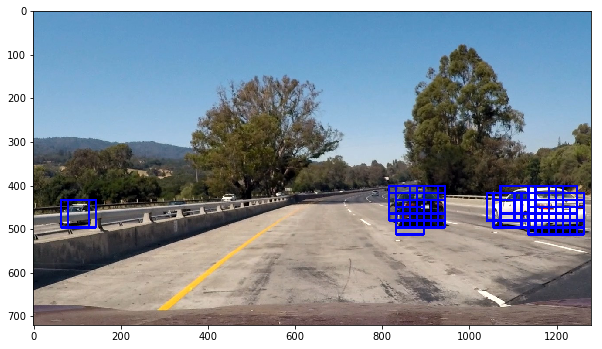

In [16]:
test_img = io.imread('test_images/test1.jpg')
hot_windows, test_output = find_cars(
    test_img, 
    ystart=400, ystop=650, 
    scale=1.0, 
    cells_per_step_overlap=PARAMS['cells_per_step_overlap'],
    clf_pl=scaled_clf, 
    use_hog=PARAMS['use_hog'], hog_cspace=PARAMS['hog_cspace'], 
    channels_for_hog=PARAMS['channels_for_hog'],
    orient=PARAMS['hog_orientations'], 
    pix_per_cell=PARAMS['hog_pixels_per_cell'], 
    cell_per_block=PARAMS['hog_cells_per_block'],
    use_spatial=PARAMS['use_spatial'], spatial_cspace=PARAMS['spatial_cspace'], 
    spatial_size=PARAMS['spatial_resize'], 
    use_hist=PARAMS['use_hist'], hist_cspace=PARAMS['hist_cspace'], 
    hist_bins=PARAMS['hist_nbins'],
    vis=True
)

plt.figure(figsize=(10,10))
plt.imshow(test_output);

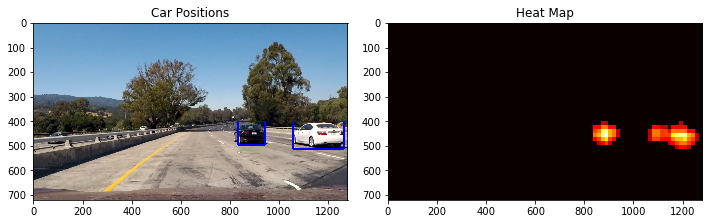

In [17]:
from scipy.ndimage.measurements import label
heat = np.zeros_like(test_img[:,:,0]).astype(np.float)
heat = add_heat(heat,hot_windows)
heat = apply_threshold(heat, 2)
heatmap = np.clip(heat, 0, 255)
labels = label(heat)
draw_img = draw_labeled_bboxes(test_img, labels)

fig = plt.figure(figsize=(10,10))
plt.subplot(121)
plt.imshow(draw_img)
plt.title('Car Positions')
plt.subplot(122)
plt.imshow(heatmap, cmap='hot')
plt.title('Heat Map')
fig.tight_layout()

In [18]:
detect_for_scale = lambda img, ystart, ystop, scale: find_cars(
    img, 
    ystart=ystart, ystop=ystop, 
    scale=scale,
    cells_per_step_overlap=PARAMS['cells_per_step_overlap'],
    clf_pl=scaled_clf, 
    use_hog=PARAMS['use_hog'], hog_cspace=PARAMS['hog_cspace'], 
    channels_for_hog=PARAMS['channels_for_hog'],
    orient=PARAMS['hog_orientations'], 
    pix_per_cell=PARAMS['hog_pixels_per_cell'], 
    cell_per_block=PARAMS['hog_cells_per_block'],
    use_spatial=PARAMS['use_spatial'], spatial_cspace=PARAMS['spatial_cspace'], 
    spatial_size=PARAMS['spatial_resize'], 
    use_hist=PARAMS['use_hist'], hist_cspace=PARAMS['hist_cspace'], 
    hist_bins=PARAMS['hist_nbins']
)

In [19]:
def video_pipeline(img, detect_fun, thresh=3):
    hot_windows = list()
    hot_windows += detect_fun(img, ystart=400, ystop=500, scale=1.0)
    hot_windows += detect_fun(img, ystart=400, ystop=600, scale=2.0)
    hot_windows += detect_fun(img, ystart=400, ystop=650, scale=3.0)
    heat = np.zeros_like(test_img[:,:,0]).astype(np.float)
    heat = add_heat(heat, hot_windows)
    heat = apply_threshold(heat, thresh)
    heatmap = np.clip(heat, 0, 255)
    labels = label(heat)
    draw_img = draw_labeled_bboxes(img, labels)
    return draw_img

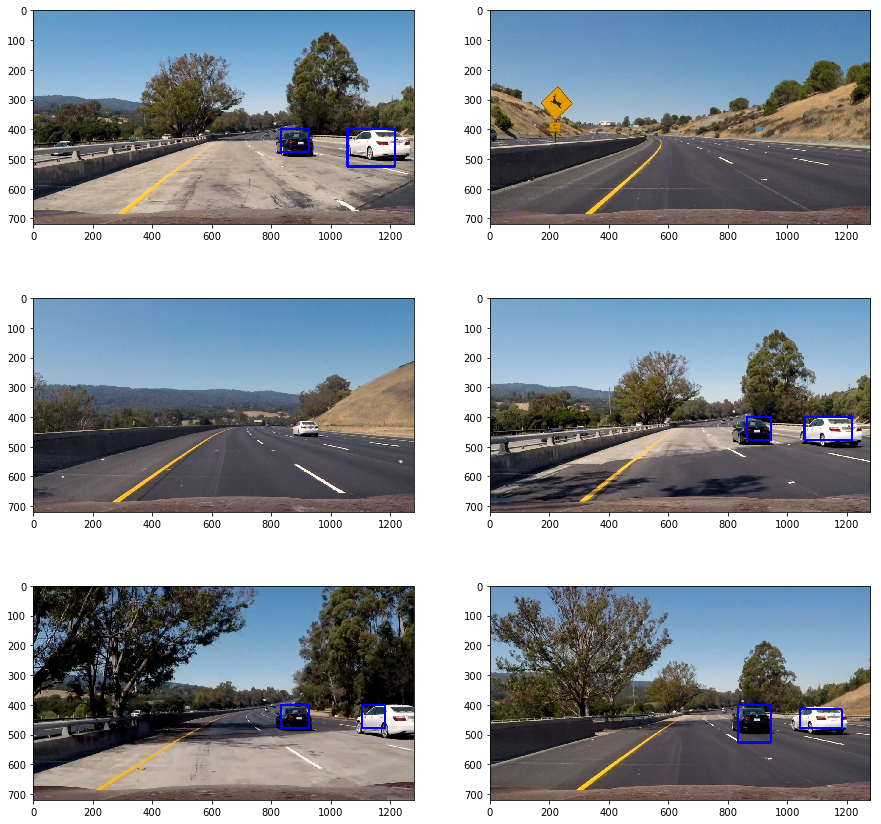

In [20]:
f, axes = plt.subplots(3,2, figsize=(15,15))
axes = axes.flatten()
for i in range(6):
    axes[i].imshow(
        video_pipeline(
            io.imread('test_images/test%i.jpg' % (i + 1)),
            detect_for_scale, 
            thresh=3
        )
    )

In [21]:
profile = False
if profile:
    %load_ext line_profiler
    %lprun -f find_cars find_cars(test_img_2, 400, 600, 1.0, 1, scaled_clf, 11, 16, 2, 32, 32)

In [22]:
print('Execution time: %0.1f s' % (time.time() - start))

Execution time: 70.8 s


In [23]:
from moviepy.editor import VideoFileClip

In [24]:
video_pl = lambda img: video_pipeline(img, detect_for_scale, thresh=3)
build_video = True
if build_video:
    test_output = 'test_solution.mp4'
    clip = VideoFileClip("test_video_2.mp4")
    test_clip = clip.fl_image(video_pl)
    %time test_clip.write_videofile(test_output, audio=False)

[MoviePy] >>>> Building video test_solution.mp4
[MoviePy] Writing video test_solution.mp4


100%|██████████| 129/129 [00:26<00:00,  4.84it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_solution.mp4 

Wall time: 27.3 s


In [25]:
build_video_final = True
if build_video_final:
    test_output = 'project_solution.mp4'
    clip = VideoFileClip('project_video.mp4')
    test_clip = clip.fl_image(video_pl)
    %time test_clip.write_videofile(test_output, audio=False)

[MoviePy] >>>> Building video project_solution.mp4
[MoviePy] Writing video project_solution.mp4


100%|█████████▉| 1260/1261 [04:22<00:00,  4.83it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_solution.mp4 

Wall time: 4min 22s
